In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_pm_normalized.pkl"

In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()
df.head(10)

,index,date,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
0,15,2017-09-28 14:00:00,16.2,-1.179450,-1.139344,-1.135621,-1.184033,-1.129486,-1.149095,-1.118787,-0.921348,0.312759,1.982213,0.0
1,16,2017-09-28 14:15:00,9.6,-1.109019,-1.086416,-1.122920,-1.102387,-1.072487,-1.129116,-1.127870,-0.976013,0.331953,2.052982,0.0
2,17,2017-09-28 14:30:00,10.3,-1.179450,-1.171101,-1.258406,-1.177752,-1.169386,-1.253987,-1.236869,-1.085343,0.312759,2.076572,0.0
3,18,2017-09-28 14:45:00,9.4,-1.138365,-1.001731,-1.207599,-1.140070,-1.009787,-1.224018,-1.264119,-0.812018,0.312759,2.005803,0.0
4,19,2017-09-28 15:00:00,10.7,-1.167711,-1.165808,-1.139855,-1.165191,-1.169386,-1.149095,-1.146036,-0.921348,0.312759,1.864265,0.0
5,20,2017-09-28 15:15:00,10.7,-1.167711,-1.202857,-1.038241,-1.158911,-1.197885,-1.039208,-1.055204,-0.866683,0.312759,1.746317,0.0
6,21,2017-09-28 15:30:00,9.6,-1.079673,-1.171101,-1.008603,-1.070985,-1.163686,-0.999249,-0.964371,-0.812018,0.312759,1.651959,0.0
7,22,2017-09-28 15:45:00,10.2,-1.032720,-1.134051,-0.995901,-1.033302,-1.123786,-0.989259,-0.891705,-0.757353,0.312759,1.581190,0.0
8,23,2017-09-28 16:00:00,9.8,-1.044458,-1.097001,-0.911222,-1.039583,-1.095286,-0.919331,-0.855372,-0.757353,0.312759,1.534011,0.0
9,24,2017-09-28 16:15:00,8.9,-1.044458,-1.044073,-1.182195,-1.039583,-1.038287,-1.174070,-0.855372,-0.702688,0.331953,1.486832,0.0


# Premier modèle: Perceptron

Pour commencer, on crée un simple modèle de réseau de neurones à 1 couches dense et 1 couche de prédiction

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

def baseline_model(dense_size, input_dim, loss='mean_squared_error', optimizer='adam'):
    # 
    model = Sequential()
    model.add(Dense(dense_size, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


### Découpage en trois jeux de données pour la validation croisée

In [5]:
# On effectue une permutation ici afin d'obtenir la répartition la plus homogène possible par jeu de donnée
df = df.reindex(np.random.permutation(df.index)) 

def split_dataframe(dataframe, percent):
    """ Méthode permettant de séparer une dataframe en deux en fonction d'un pourcentage donné
    """
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    """ Retourne X et y en prenant une dataframe en argument
    """
    return (np.array(df[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh',\
                         't_grad', 'pressure', 'pluvio']]),\
            np.array(df['ref']))

df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

### Distribution des données sur les 3 jeux de validation croisée

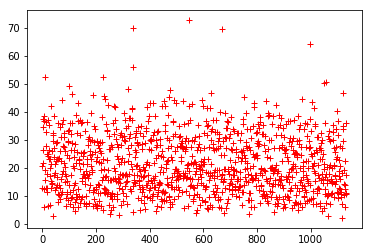

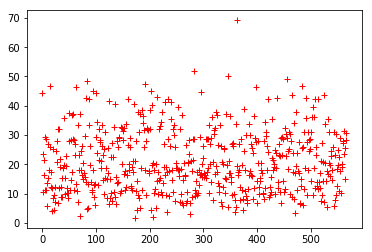

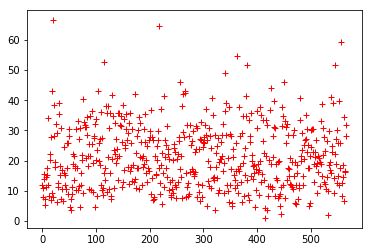

In [6]:
plt.plot(y_train, '+r')
plt.show()
plt.plot(y_valid, '+r')
plt.show()
plt.plot(y_test, '+r')
plt.show()

In [7]:
model = baseline_model(32, X_train.shape[1], 'mean_squared_error', 'adam')
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=25)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Train on 1133 samples, validate on 567 samples
Epoch 1/5000
1133/1133 [==============================] - 0s 119us/step - loss: 560.6368 - val_loss: 536.7058
Epoch 2/5000
1133/1133 [==============================] - 0s 33us/step - loss: 542.2569 - val_loss: 510.5621
Epoch 3/5000
1133/1133 [==============================] - 0s 33us/step - loss: 509.7844 - val_loss: 468.4246
Epoch 4/5000
1133/1133 [==============================] - 0s 34us/step - loss: 462.3291 - val_loss: 413.1542
Epoch 5/5000
1133/1133 [==============================] 

1133/1133 [==============================] - 0s 32us/step - loss: 48.2924 - val_loss: 53.8572
Epoch 71/5000
1133/1133 [==============================] - 0s 35us/step - loss: 48.2577 - val_loss: 53.8102
Epoch 72/5000
1133/1133 [==============================] - 0s 32us/step - loss: 48.3292 - val_loss: 53.6461
Epoch 73/5000
1133/1133 [==============================] - 0s 31us/step - loss: 48.0182 - val_loss: 53.7059
Epoch 74/5000
1133/1133 [==============================] - 0s 31us/step - loss: 48.0668 - val_loss: 53.5100
Epoch 75/5000
1133/1133 [==============================] - 0s 32us/step - loss: 47.8396 - val_loss: 53.5258
Epoch 76/5000
1133/1133 [==============================] - 0s 34us/step - loss: 47.7496 - val_loss: 53.3724
Epoch 77/5000
1133/1133 [==============================] - 0s 34us/step - loss: 47.6799 - val_loss: 53.4654
Epoch 78/5000
1133/1133 [==============================] - 0s 34us/step - loss: 47.6456 - val_loss: 53.2285
Epoch 79/5000
1133/1133 [=================

1133/1133 [==============================] - 0s 34us/step - loss: 44.3267 - val_loss: 49.8897
Epoch 146/5000
1133/1133 [==============================] - 0s 34us/step - loss: 44.4639 - val_loss: 49.8170
Epoch 147/5000
1133/1133 [==============================] - 0s 33us/step - loss: 44.4498 - val_loss: 49.7643
Epoch 148/5000
1133/1133 [==============================] - 0s 33us/step - loss: 44.3677 - val_loss: 49.7105
Epoch 149/5000
1133/1133 [==============================] - 0s 34us/step - loss: 44.3038 - val_loss: 49.7594
Epoch 150/5000
1133/1133 [==============================] - 0s 32us/step - loss: 44.3149 - val_loss: 49.6329
Epoch 151/5000
1133/1133 [==============================] - 0s 33us/step - loss: 44.3427 - val_loss: 49.5913
Epoch 152/5000
1133/1133 [==============================] - 0s 32us/step - loss: 44.2352 - val_loss: 49.5891
Epoch 153/5000
1133/1133 [==============================] - 0s 32us/step - loss: 44.1875 - val_loss: 49.5972
Epoch 154/5000
1133/1133 [========

1133/1133 [==============================] - 0s 32us/step - loss: 41.7587 - val_loss: 46.8987
Epoch 221/5000
1133/1133 [==============================] - 0s 35us/step - loss: 41.7322 - val_loss: 46.9932
Epoch 222/5000
1133/1133 [==============================] - 0s 33us/step - loss: 41.7259 - val_loss: 47.0346
Epoch 223/5000
1133/1133 [==============================] - 0s 32us/step - loss: 41.6036 - val_loss: 46.8428
Epoch 224/5000
1133/1133 [==============================] - 0s 31us/step - loss: 41.5149 - val_loss: 46.7669
Epoch 225/5000
1133/1133 [==============================] - 0s 32us/step - loss: 41.5078 - val_loss: 46.9210
Epoch 226/5000
1133/1133 [==============================] - 0s 33us/step - loss: 41.5007 - val_loss: 46.8510
Epoch 227/5000
1133/1133 [==============================] - 0s 32us/step - loss: 41.4993 - val_loss: 46.6471
Epoch 228/5000
1133/1133 [==============================] - 0s 34us/step - loss: 41.5028 - val_loss: 46.7338
Epoch 229/5000
1133/1133 [========

1133/1133 [==============================] - 0s 33us/step - loss: 39.5926 - val_loss: 44.8584
Epoch 296/5000
1133/1133 [==============================] - 0s 35us/step - loss: 39.5561 - val_loss: 44.8400
Epoch 297/5000
1133/1133 [==============================] - 0s 37us/step - loss: 39.5038 - val_loss: 44.8283
Epoch 298/5000
1133/1133 [==============================] - 0s 39us/step - loss: 39.5114 - val_loss: 44.6874
Epoch 299/5000
1133/1133 [==============================] - 0s 37us/step - loss: 39.4984 - val_loss: 44.8070
Epoch 300/5000
1133/1133 [==============================] - 0s 35us/step - loss: 39.5077 - val_loss: 44.7858
Epoch 301/5000
1133/1133 [==============================] - 0s 34us/step - loss: 39.4917 - val_loss: 44.6183
Epoch 302/5000
1133/1133 [==============================] - 0s 33us/step - loss: 39.5173 - val_loss: 44.7054
Epoch 303/5000
1133/1133 [==============================] - 0s 32us/step - loss: 39.3877 - val_loss: 44.6343
Epoch 304/5000
1133/1133 [========

1133/1133 [==============================] - 0s 34us/step - loss: 37.5269 - val_loss: 43.0956
Epoch 371/5000
1133/1133 [==============================] - 0s 33us/step - loss: 37.5715 - val_loss: 43.0662
Epoch 372/5000
1133/1133 [==============================] - 0s 33us/step - loss: 37.6755 - val_loss: 42.9891
Epoch 373/5000
1133/1133 [==============================] - 0s 33us/step - loss: 37.4380 - val_loss: 42.9927
Epoch 374/5000
1133/1133 [==============================] - 0s 33us/step - loss: 37.4519 - val_loss: 42.9709
Epoch 375/5000
1133/1133 [==============================] - 0s 33us/step - loss: 37.3087 - val_loss: 42.9898
Epoch 376/5000
1133/1133 [==============================] - 0s 32us/step - loss: 37.3655 - val_loss: 42.9065
Epoch 377/5000
1133/1133 [==============================] - 0s 33us/step - loss: 37.3130 - val_loss: 43.0201
Epoch 378/5000
1133/1133 [==============================] - 0s 32us/step - loss: 37.3923 - val_loss: 43.0012
Epoch 379/5000
1133/1133 [========

1133/1133 [==============================] - 0s 33us/step - loss: 34.8577 - val_loss: 41.4475
Epoch 446/5000
1133/1133 [==============================] - 0s 37us/step - loss: 34.8020 - val_loss: 41.4147
Epoch 447/5000
1133/1133 [==============================] - 0s 36us/step - loss: 34.7449 - val_loss: 41.3678
Epoch 448/5000
1133/1133 [==============================] - 0s 32us/step - loss: 34.7850 - val_loss: 41.4018
Epoch 449/5000
1133/1133 [==============================] - 0s 34us/step - loss: 34.7768 - val_loss: 41.4429
Epoch 450/5000
1133/1133 [==============================] - 0s 35us/step - loss: 34.7048 - val_loss: 41.3670
Epoch 451/5000
1133/1133 [==============================] - 0s 35us/step - loss: 34.6270 - val_loss: 41.2467
Epoch 452/5000
1133/1133 [==============================] - 0s 34us/step - loss: 34.6479 - val_loss: 41.3953
Epoch 453/5000
1133/1133 [==============================] - 0s 34us/step - loss: 34.6147 - val_loss: 41.2571
Epoch 454/5000
1133/1133 [========

1133/1133 [==============================] - 0s 33us/step - loss: 33.2339 - val_loss: 40.2540
Epoch 521/5000
1133/1133 [==============================] - 0s 37us/step - loss: 33.4097 - val_loss: 40.3493
Epoch 522/5000
1133/1133 [==============================] - 0s 35us/step - loss: 33.1742 - val_loss: 40.1175
Epoch 523/5000
1133/1133 [==============================] - 0s 33us/step - loss: 33.1756 - val_loss: 40.1222
Epoch 524/5000
1133/1133 [==============================] - 0s 34us/step - loss: 33.2220 - val_loss: 40.1567
Epoch 525/5000
1133/1133 [==============================] - 0s 34us/step - loss: 33.1279 - val_loss: 40.0291
Epoch 526/5000
1133/1133 [==============================] - 0s 32us/step - loss: 33.0913 - val_loss: 40.2412
Epoch 527/5000
1133/1133 [==============================] - 0s 31us/step - loss: 33.1561 - val_loss: 40.1531
Epoch 528/5000
1133/1133 [==============================] - 0s 32us/step - loss: 33.2901 - val_loss: 40.1160
Epoch 529/5000
1133/1133 [========

1133/1133 [==============================] - 0s 33us/step - loss: 32.4241 - val_loss: 39.6804
Epoch 596/5000
1133/1133 [==============================] - 0s 31us/step - loss: 32.2856 - val_loss: 39.4514
Epoch 597/5000
1133/1133 [==============================] - 0s 32us/step - loss: 32.2814 - val_loss: 39.4570
Epoch 598/5000
1133/1133 [==============================] - 0s 31us/step - loss: 32.3938 - val_loss: 39.6024
Epoch 599/5000
1133/1133 [==============================] - 0s 31us/step - loss: 32.2936 - val_loss: 39.4262
Epoch 600/5000
1133/1133 [==============================] - 0s 33us/step - loss: 32.2082 - val_loss: 39.5188
Epoch 601/5000
1133/1133 [==============================] - 0s 31us/step - loss: 32.2305 - val_loss: 39.5265
Epoch 602/5000
1133/1133 [==============================] - 0s 31us/step - loss: 32.3112 - val_loss: 39.4989
Epoch 603/5000
1133/1133 [==============================] - 0s 31us/step - loss: 32.2953 - val_loss: 39.5364
Epoch 604/5000
1133/1133 [========

1133/1133 [==============================] - 0s 33us/step - loss: 31.7112 - val_loss: 39.2546
Epoch 671/5000
1133/1133 [==============================] - 0s 36us/step - loss: 31.7035 - val_loss: 39.1823
Epoch 672/5000
1133/1133 [==============================] - 0s 31us/step - loss: 31.6591 - val_loss: 39.2969
Epoch 673/5000
1133/1133 [==============================] - 0s 32us/step - loss: 31.7383 - val_loss: 39.2768
Epoch 674/5000
1133/1133 [==============================] - 0s 32us/step - loss: 31.8103 - val_loss: 39.3234
Epoch 675/5000
1133/1133 [==============================] - 0s 32us/step - loss: 31.7051 - val_loss: 39.2508
Epoch 676/5000
1133/1133 [==============================] - 0s 31us/step - loss: 31.6533 - val_loss: 39.1555
Epoch 677/5000
1133/1133 [==============================] - 0s 33us/step - loss: 31.6175 - val_loss: 39.1898
Epoch 678/5000
1133/1133 [==============================] - 0s 33us/step - loss: 31.7097 - val_loss: 39.1640
Epoch 679/5000
1133/1133 [========

1133/1133 [==============================] - 0s 31us/step - loss: 31.1832 - val_loss: 38.9078
Epoch 746/5000
1133/1133 [==============================] - 0s 31us/step - loss: 31.3124 - val_loss: 38.9868
Epoch 747/5000
1133/1133 [==============================] - 0s 32us/step - loss: 31.2669 - val_loss: 39.0447
Epoch 748/5000
1133/1133 [==============================] - 0s 32us/step - loss: 31.3545 - val_loss: 38.9286
Epoch 00748: early stopping


### Courbes de résultats pour modèle à une couche dense

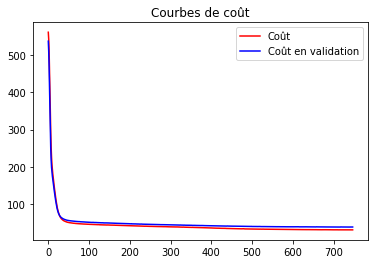

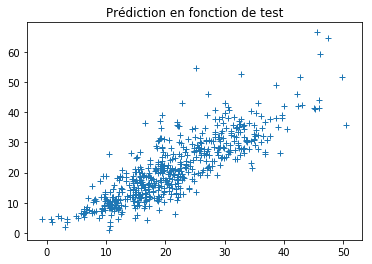

In [8]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## MLP 2 Couches

### Définition du modèle

In [9]:
def two_layers_mlp_model(nb_units, dense_size, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(Dense(dense_size, input_dim=dense_size, kernel_initializer='normal', activation='relu'))
    model.add(Dense(dense_size//2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

model = two_layers_mlp_model(32, X_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 60        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 198
Trainable params: 198
Non-trainable params: 0
_________________________________________________________________


### Apprentissage

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=25)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1133 samples, validate on 567 samples
Epoch 1/5000
1133/1133 [==============================] - 0s 119us/step - loss: 567.1710 - val_loss: 549.9921
Epoch 2/5000
1133/1133 [==============================] - 0s 33us/step - loss: 563.3778 - val_loss: 543.6083
Epoch 3/5000
1133/1133 [==============================] - 0s 32us/step - loss: 552.3337 - val_loss: 525.8871
Epoch 4/5000
1133/1133 [==============================] - 0s 33us/step - loss: 526.6533 - val_loss: 488.7984
Epoch 5/5000
1133/1133 [==============================] - 0s 33us/step - loss: 479.9334 - val_loss: 429.6788
Epoch 6/5000
1133/1133 [==============================] - 0s 34us/step - loss: 413.7401 - val_loss: 355.0939
Epoch 7/5000
1133/1133 [==============================] - 0s 33us/step - loss: 339.1698 - val_loss: 283.4389
Epoch 8/5000
1133/1133 [==============================] - 0s 33us/step - loss: 274.9105 - val_loss: 232.8089
Epoch 9/5000
1133/1133 [==============================] - 0s 34us/step - loss: 2

1133/1133 [==============================] - 0s 37us/step - loss: 58.7709 - val_loss: 63.3582
Epoch 77/5000
1133/1133 [==============================] - 0s 37us/step - loss: 58.4764 - val_loss: 63.1578
Epoch 78/5000
1133/1133 [==============================] - 0s 34us/step - loss: 58.3846 - val_loss: 62.9610
Epoch 79/5000
1133/1133 [==============================] - 0s 35us/step - loss: 58.2475 - val_loss: 62.8860
Epoch 80/5000
1133/1133 [==============================] - 0s 35us/step - loss: 58.1431 - val_loss: 62.9171
Epoch 81/5000
1133/1133 [==============================] - 0s 35us/step - loss: 57.9721 - val_loss: 62.5298
Epoch 82/5000
1133/1133 [==============================] - 0s 35us/step - loss: 57.9975 - val_loss: 62.3883
Epoch 83/5000
1133/1133 [==============================] - 0s 35us/step - loss: 57.9137 - val_loss: 62.3676
Epoch 84/5000
1133/1133 [==============================] - 0s 35us/step - loss: 57.7016 - val_loss: 62.2081
Epoch 85/5000
1133/1133 [=================

1133/1133 [==============================] - 0s 35us/step - loss: 45.7121 - val_loss: 51.5474
Epoch 152/5000
1133/1133 [==============================] - 0s 34us/step - loss: 45.4817 - val_loss: 51.3154
Epoch 153/5000
1133/1133 [==============================] - 0s 34us/step - loss: 45.2974 - val_loss: 50.9760
Epoch 154/5000
1133/1133 [==============================] - 0s 34us/step - loss: 45.2585 - val_loss: 51.0441
Epoch 155/5000
1133/1133 [==============================] - 0s 35us/step - loss: 45.1444 - val_loss: 50.8932
Epoch 156/5000
1133/1133 [==============================] - 0s 36us/step - loss: 45.0588 - val_loss: 50.6262
Epoch 157/5000
1133/1133 [==============================] - 0s 36us/step - loss: 45.1008 - val_loss: 50.6318
Epoch 158/5000
1133/1133 [==============================] - 0s 35us/step - loss: 44.8816 - val_loss: 50.5140
Epoch 159/5000
1133/1133 [==============================] - 0s 37us/step - loss: 44.9540 - val_loss: 50.2922
Epoch 160/5000
1133/1133 [========

1133/1133 [==============================] - 0s 35us/step - loss: 41.5967 - val_loss: 46.7766
Epoch 227/5000
1133/1133 [==============================] - 0s 34us/step - loss: 41.5909 - val_loss: 46.6894
Epoch 228/5000
1133/1133 [==============================] - 0s 34us/step - loss: 41.5031 - val_loss: 46.6607
Epoch 229/5000
1133/1133 [==============================] - 0s 35us/step - loss: 41.5560 - val_loss: 46.7087
Epoch 230/5000
1133/1133 [==============================] - 0s 34us/step - loss: 41.4068 - val_loss: 46.5708
Epoch 231/5000
1133/1133 [==============================] - 0s 33us/step - loss: 41.4761 - val_loss: 46.5864
Epoch 232/5000
1133/1133 [==============================] - 0s 34us/step - loss: 41.5030 - val_loss: 46.5764
Epoch 233/5000
1133/1133 [==============================] - 0s 34us/step - loss: 41.5006 - val_loss: 46.5915
Epoch 234/5000
1133/1133 [==============================] - 0s 33us/step - loss: 41.4488 - val_loss: 46.5436
Epoch 235/5000
1133/1133 [========

1133/1133 [==============================] - 0s 34us/step - loss: 40.6394 - val_loss: 45.5226
Epoch 302/5000
1133/1133 [==============================] - 0s 34us/step - loss: 40.7361 - val_loss: 45.5021
Epoch 303/5000
1133/1133 [==============================] - 0s 34us/step - loss: 40.5937 - val_loss: 45.6385
Epoch 304/5000
1133/1133 [==============================] - 0s 36us/step - loss: 40.6034 - val_loss: 45.4379
Epoch 305/5000
1133/1133 [==============================] - 0s 36us/step - loss: 40.5309 - val_loss: 45.3889
Epoch 306/5000
1133/1133 [==============================] - 0s 33us/step - loss: 40.7255 - val_loss: 45.6391
Epoch 307/5000
1133/1133 [==============================] - 0s 35us/step - loss: 40.9100 - val_loss: 45.6559
Epoch 308/5000
1133/1133 [==============================] - 0s 35us/step - loss: 40.6677 - val_loss: 45.5206
Epoch 309/5000
1133/1133 [==============================] - 0s 34us/step - loss: 40.6351 - val_loss: 45.5177
Epoch 310/5000
1133/1133 [========

1133/1133 [==============================] - 0s 35us/step - loss: 40.2670 - val_loss: 45.2036
Epoch 377/5000
1133/1133 [==============================] - 0s 48us/step - loss: 39.8490 - val_loss: 45.0741
Epoch 378/5000
1133/1133 [==============================] - 0s 35us/step - loss: 39.9842 - val_loss: 45.3353
Epoch 379/5000
1133/1133 [==============================] - 0s 35us/step - loss: 39.8385 - val_loss: 45.1044
Epoch 380/5000
1133/1133 [==============================] - 0s 36us/step - loss: 39.8829 - val_loss: 45.1588
Epoch 381/5000
1133/1133 [==============================] - 0s 37us/step - loss: 39.9001 - val_loss: 45.0774
Epoch 382/5000
1133/1133 [==============================] - 0s 40us/step - loss: 39.8246 - val_loss: 45.0915
Epoch 383/5000
1133/1133 [==============================] - 0s 43us/step - loss: 39.7455 - val_loss: 45.1049
Epoch 384/5000
1133/1133 [==============================] - 0s 37us/step - loss: 39.8243 - val_loss: 45.1118
Epoch 385/5000
1133/1133 [========

### Courbes de résultats pour modèle à deux couches denses

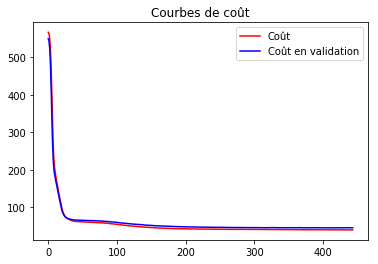

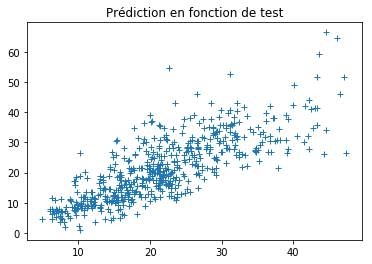

In [11]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

# Conclusion

Sur ces premiers tests, le modèle a une couche a l'air un peu plus performant que le modèle a deux couches. En effet, le modèle prédictif est presque linéaire. Essayons maintenant d'implémenter un modèle récurrent

In [12]:
from keras.layers import Dropout

def two_layers_mlp_model_dropout(nb_units, dense_size, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(Dense(dense_size, input_dim=dense_size, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_size//2, input_dim=dense_size, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

model = two_layers_mlp_model_dropout(16, X_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 60        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 198
Trainable params: 198
Non-trainable params: 0
_________________________________________________________________


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=5)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1133 samples, validate on 567 samples
Epoch 1/5000
1133/1133 [==============================] - 0s 209us/step - loss: 567.2120 - val_loss: 549.9995
Epoch 2/5000
1133/1133 [==============================] - 0s 42us/step - loss: 563.1461 - val_loss: 542.9506
Epoch 3/5000
1133/1133 [==============================] - 0s 38us/step - loss: 550.6352 - val_loss: 522.5783
Epoch 4/5000
1133/1133 [==============================] - 0s 39us/step - loss: 521.8731 - val_loss: 480.6323
Epoch 5/5000
1133/1133 [==============================] - 0s 38us/step - loss: 468.5323 - val_loss: 410.9603
Epoch 6/5000
1133/1133 [==============================] - 0s 39us/step - loss: 393.6401 - val_loss: 330.7978
Epoch 7/5000
1133/1133 [==============================] - 0s 39us/step - loss: 323.8352 - val_loss: 269.2981
Epoch 8/5000
1133/1133 [==============================] - 0s 38us/step - loss: 288.8412 - val_loss: 232.7250
Epoch 9/5000
1133/1133 [==============================] - 0s 38us/step - loss: 2

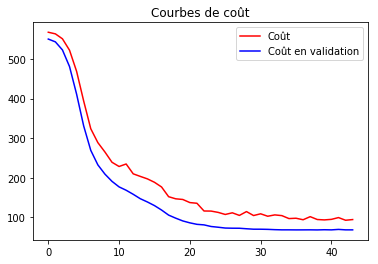

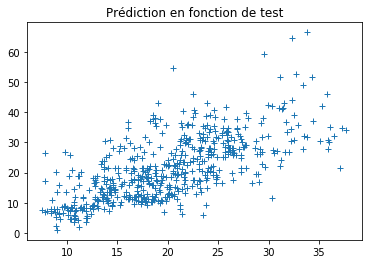

In [14]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()